# Project Zillow

- Predict the tax assessed property value of Zillow Single Family Residential properties with transaction dates in 2017.


# Goal

- Identify drivers of property value.
- Use drivers to develop a machine learning model to predict Single Family Residential property value.

# Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures

# local
from wrangle import acquire_zillow, clean_zillow, wrangle_zillow, train_val_test, xy_split
from explore import dist_of_nums, plot_variable_pairs, plot_categorical_and_continuous_vars, evaluate_correlation
from evaluate import plot_residuals, regression_errors, baseline_mean_errors, better_than_baseline
from model import eval_model, train_model, train_and_evaluate_model, scale_data
from math import sqrt

# Acquire

- Data acquired from Codeup MySQL DB
- Data initially acquired on 7 Sep, 2023.
- It contained 52,441 rows and 15 columns before cleaning.
- Each row represents a unique parcel for each transaction it had in 2017.
- Each column represents an element of the parcel.

# Prepare

**Prepare Actions:**
 - list actions taken

In [2]:
# function (wrangle) and split maybe
df = wrangle_zillow()

In [3]:
train, val, test = train_val_test(df)

### Quick view of data,

In [4]:
# displaying first five rows of zillow dataframe.
train.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
40340,12115385,2.0,3,1218,2,34164673.0,-118126949.0,9251,3101,96292,0,1921,432527,6.037462e+13,6037,California,Los Angeles County
49528,12825439,2.0,3,1662,2,33931418.0,-118001601.0,6455,3101,96172,0,1954,169135,6.037504e+13,6037,California,Los Angeles County
24808,12668213,1.0,3,1580,1,33821835.0,-118387104.0,7509,3101,96123,0,1948,163387,6.037621e+13,6037,California,Los Angeles County
49262,12266229,1.0,3,1079,1,33906624.0,-118240829.0,6249,3101,96092,0,1954,163308,6.037541e+13,6037,California,Los Angeles County
5656,14379497,3.0,4,1986,3,33611735.0,-117688925.0,7560,1286,96995,8,1968,461551,6.059032e+13,6059,California,Orange County


# Explore

In [5]:
## improve functions for these quesiton visuals

## Question 1

* Does bedrooms have a relationship with home_value?
  
<!--bedrooms is categorical and home_value is continous-->

In [6]:
train.bedrooms.value_counts()

3     16246
4     10477
2      5798
5      2723
6       430
1       421
7        73
0        21
8        15
9         5
10        2
11        1
Name: bedrooms, dtype: int64

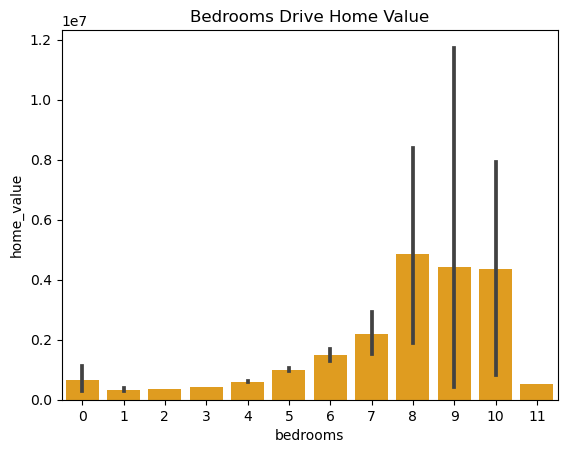

In [7]:
sns.barplot(data = train, x='bedrooms', y='home_value', color='orange').set(title='Bedrooms Drive Home Value')
plt.show()

**Takeaway:**  
bedrooms clearly have a relationship that appears linear. This will be a good feature to use to predict single family residential properties in the modeling phase.

## Question 2

* Does home_value have a correlation with year built?

home_value is continous and year_built is categorical

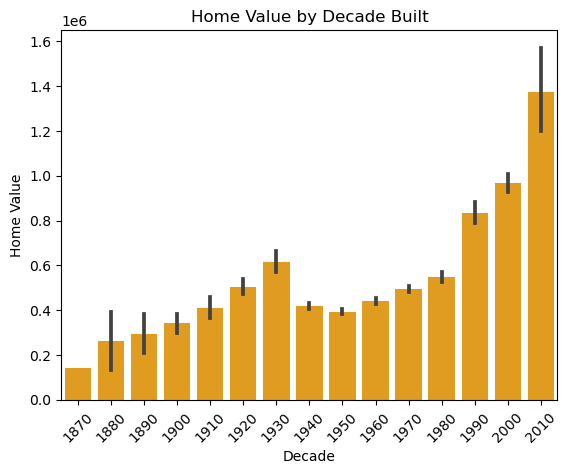

In [8]:
# Create a new column 'decade' by binning 'year_built' values into decades
train['decade'] = (train['year_built'] // 10) * 10

# Create a bar plot to visualize the relationship between 'decade' and 'tax_amount'
plt.figure()
sns.barplot(data=train, x='decade', y='home_value', color='orange')
plt.xlabel('Decade')
plt.ylabel('Home Value')
plt.title('Home Value by Decade Built')
plt.xticks(rotation=45)
plt.show()

# Question 3  

- Does home_value have a correlation with area?  
<!--homw_value and area is continous.-->

**Null Hypothesis($H0$):** There is **a significant correlation** between the area of the property and home value.  

**Alternative Hypothesis($Ha$):** There **is no significant correlation** between area of the property and home value.

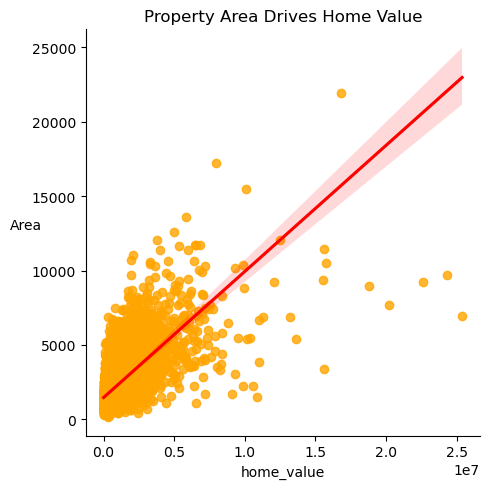

In [9]:
sns.lmplot(data=train, x='home_value', y='area', scatter_kws={'color': 'orange'}, line_kws={'color': 'red'}).set(title='Property Area Drives Home Value')
plt.ylabel('Area',rotation=0)
plt.tight_layout()
plt.show()

In [10]:
correlation_coefficient, p_value, conclusion = evaluate_correlation(train.area, train.home_value, method="Pearson")
print(f'{conclusion}\n\np-value: {p_value}')

Reject the null hypothesis.

There is a significant linear correlation between area and home_value.

p-value: 0.0


# Question 4

- Does home_value have a correlation with the property lot area?  
<!--homw_value and area is continous.-->

**Null Hypothesis($H0$):** There is **a significant correlation** between the lot area of the property and home value.  

**Alternative Hypothesis($Ha$):** There **is no significant correlation** between lot area of the property and home value.

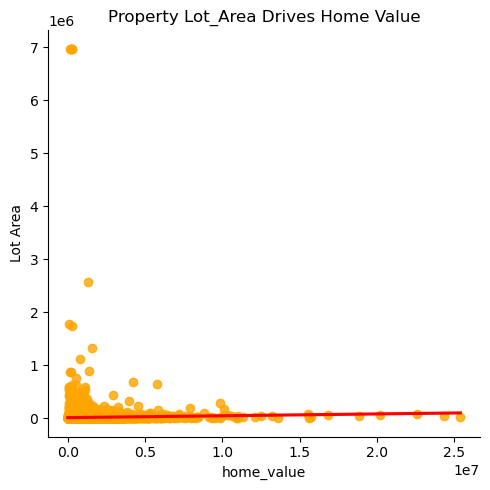

In [11]:
sns.lmplot(data=train, x='home_value', y='lot_area', scatter_kws={'color': 'orange'}, line_kws={'color': 'red'}).set(title='Property Lot_Area Drives Home Value')
plt.ylabel('Lot Area')
plt.tight_layout()
plt.show()

In [12]:
correlation_coefficient, p_value, conclusion = evaluate_correlation(train.lot_area, train.home_value, method="Spearman")
print(f'{conclusion}\n\nCorrelation Coefficient: {correlation_coefficient:.4f}\n\np-value: {p_value}')

Reject the null hypothesis.

There is a significant linear correlation between lot_area and home_value.

Correlation Coefficient: 0.1534

p-value: 1.2190776018275202e-189


In [13]:
# answer takeaway

# Explore Summary

- The datset consist of alot of LA county homes,
- All counties are in the state of california.
- There is a right skew to quite a few dsitributions between categorical and continuous data.
- home value is on the lower range of the scale when they are all compared.
- larger homes exists in ventura county as well as the number of room_cnt and lot_area versus the other counties.
- most properties are listed with 0 in la county, i'm not entirely sure why, may be an issue
- the data is proportionate with home detail features versus geolocation and outside markers for single residential properties.

# Features for modeling

* **Features that will be used:**
  * *home_value*(target)  
 

* **Some features that may be useful:**  
    * *parcel_id*
    * *bathrooms*
    * *bedrooms*
    * *area*
    * *full_bath_cnt*
    * *latitude*
    * *longitude*
    * *lot_area*
    * *region_id_county*
    * *regionidzip*
    * *room_cnt*
    * *year_built*
    * *census_tract_and_block*
    * *fips*
    * *state*
    * *county*

# Modeling

Root Mean Squared Error Calculated Model Significance will be the evaluation metric

Given more time I could gather more data and experiment with the hyperparameter configurations providing possibly a better significance and lower RMSE.

Target feature is home_value

Baseline RMSE is apprximately $716,000

Models will be developed and evaluated using 2 model different hyperparameter set for different features used.

RandomForestRegresssor
XGBoostRegressor

Models will be evaluated on train and validate datasets
Best performing model will be the only one evaluated on the test dataset.

## Best of 3 model configuration

In [14]:
# create a function to return baseline

In [15]:
#re-reading data to get train subset out of sampled change
df = wrangle_zillow()

#have to drop categorical features becasue regression model only uses numerical features.
df = df.drop(columns=['county', 'state'])

train, val, test = train_val_test(df)

# checking shape of subset dfs
train.shape, val.shape, test.shape

((36212, 15), (7760, 15), (7760, 15))

In [16]:
# need to have the same shape before x, y split
train['decade'] = (train['year_built'] // 10) * 10
val['decade'] = (val['year_built'] // 10) * 10
test['decade'] = (test['year_built'] // 10) * 10

In [17]:
# additional manipulation
train = train[(train['home_value'] < 3_000_000)]

In [18]:
# checking shape of subset df
train.shape, val.shape, test.shape

((35832, 16), (7760, 16), (7760, 16))

In [19]:
#splitted subsets into x and y only for train and val, not doing test just yet
X_train, y_train = xy_split(train, 'home_value')
X_val, y_val = xy_split(val, 'home_value')

In [20]:
# checking mean to see if it is good for baseline, doesn't seem like it so far.
y_train.mean()

476209.9236994865

In [21]:
# The baseline will be median, assigned bl as y_train median value
bl = y_train.median()
bl

370000.0

In [22]:
# created a DF to work with
preds = pd.DataFrame({'y_actual' : y_train,
              'y_baseline': y_train.median()})

preds.head()

,y_actual,y_baseline
40340,432527,370000.0
49528,169135,370000.0
24808,163387,370000.0
49262,163308,370000.0
5656,461551,370000.0


In [23]:
preds['y_baseline_residuals'] = preds['y_baseline'] - preds['y_actual']
preds.head()

,y_actual,y_baseline,y_baseline_residuals
40340,432527,370000.0,-62527.0
49528,169135,370000.0,200865.0
24808,163387,370000.0,206613.0
49262,163308,370000.0,206692.0
5656,461551,370000.0,-91551.0


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35832 entries, 40340 to 16057
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   parcel_id               35832 non-null  int64  
 1   bathrooms               35832 non-null  float64
 2   bedrooms                35832 non-null  int64  
 3   area                    35832 non-null  int64  
 4   full_bath_cnt           35832 non-null  int64  
 5   latitude                35832 non-null  float64
 6   longitude               35832 non-null  float64
 7   lot_area                35832 non-null  int64  
 8   region_id_county        35832 non-null  int64  
 9   regionidzip             35832 non-null  int64  
 10  room_cnt                35832 non-null  int64  
 11  year_built              35832 non-null  int64  
 12  home_value              35832 non-null  int64  
 13  census_tract_and_block  35832 non-null  float64
 14  fips                    35832 non-

In [25]:
lm = LinearRegression()

lm.fit(X_train, y_train)

preds['y_hat'] = lm.predict(X_train)

In [26]:
lm

LinearRegression()

In [27]:
# y-hat resids calc
preds['y_hat_residuals'] = preds['y_hat'] - preds['y_actual']
preds.head()

,y_actual,y_baseline,y_baseline_residuals,y_hat,y_hat_residuals
40340,432527,370000.0,-62527.0,265564.286872,-166962.713128
49528,169135,370000.0,200865.0,423419.453216,254284.453216
24808,163387,370000.0,206613.0,468741.615115,305354.615115
49262,163308,370000.0,206692.0,257506.532383,94198.532383
5656,461551,370000.0,-91551.0,484934.856444,23383.856444


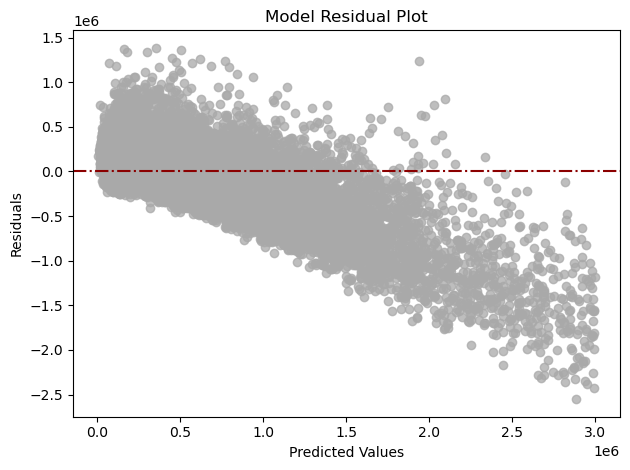


-------------------------------------

Model SSE: 3720143058974610.00

Model ESS: 2936908864587266.00

Model TSS: 6657038403121251.00

Model MSE: 103821808968.93

Model RMSE: 322213.92


-------------------------------------
Baseline SSE: 6657038403121251.00

Baseline MSE: 185784728821.20

Baseline RMSE: 431027.53


-------------------------------------

Is the model better than the baseline? True


In [28]:
plot_residuals(preds.y_actual, preds.y_hat)

print(f"\n-------------------------------------")


SSE, ESS, TSS, MSE, RMSE = regression_errors(preds.y_actual, preds.y_hat)

print(f"\nModel SSE: {SSE:.2f}\n")

print(f"Model ESS: {ESS:.2f}\n")

print(f"Model TSS: {TSS:.2f}\n")

print(f"Model MSE: {MSE:.2f}\n")

print(f"Model RMSE: {RMSE:.2f}\n")

print(f"\n-------------------------------------")

SSE_baseline, MSE_baseline, RMSE_baseline = baseline_mean_errors(preds.y_actual)

print(f"Baseline SSE: {SSE_baseline:.2f}\n")

print(f"Baseline MSE: {MSE_baseline:.2f}\n")

print(f"Baseline RMSE: {RMSE_baseline:.2f}\n")

print(f"\n-------------------------------------")

print(f"\nIs the model better than the baseline? {better_than_baseline(preds.y_actual, preds.y_hat)}")

In [29]:
to_scale = ['parcel_id', 'bathrooms', 'bedrooms', 'area', 'full_bath_cnt', 'latitude', 'longitude', 'lot_area',	'region_id_county', 'regionidzip', 'room_cnt', 'year_built', 'census_tract_and_block', 'fips']
train, val, test = scale_data(train, val, test, to_scale)
train.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,decade
40340,0.009219,0.111111,0.272727,0.098086,0.111111,0.559834,0.702287,0.001293,1.0,0.001021,0.000000,0.311594,432527,0.000009,0.000000,1920
49528,0.013882,0.111111,0.272727,0.138940,0.111111,0.401324,0.767577,0.000892,1.0,0.000626,0.000000,0.550725,169135,0.000010,0.000000,1950
24808,0.012850,0.000000,0.272727,0.131395,0.000000,0.326856,0.566782,0.001043,1.0,0.000464,0.000000,0.507246,163387,0.000012,0.000000,1940
49262,0.010209,0.000000,0.272727,0.085296,0.000000,0.384475,0.642972,0.000863,1.0,0.000362,0.000000,0.550725,163308,0.000010,0.000000,1950
5656,0.024090,0.222222,0.363636,0.168752,0.222222,0.184081,0.930438,0.001051,0.0,0.003336,0.571429,0.652174,461551,0.000519,0.297297,1960


In [30]:
#splitted subsets into x and y only for train and val, not doing test just yet
X_train, y_train = xy_split(train, 'home_value')
X_val, y_val = xy_split(val, 'home_value')

In [31]:
y_train.mean(), y_train.median()
bl = pd.DataFrame({"y_actual" : y_train,
                   "y_mean" : y_train.mean(),
                   "y_median" : y_train.median()})
bl.head()

,y_actual,y_mean,y_median
40340,432527,476209.923699,370000.0
49528,169135,476209.923699,370000.0
24808,163387,476209.923699,370000.0
49262,163308,476209.923699,370000.0
5656,461551,476209.923699,370000.0


## Model 1

In [32]:
rfr = RandomForestRegressor()
trained_model, train_rmse, val_rmse = train_and_evaluate_model(rfr, X_train, y_train, X_val, y_val)

The train RMSE is 106956.14.

The validation RMSE is 529057.73.




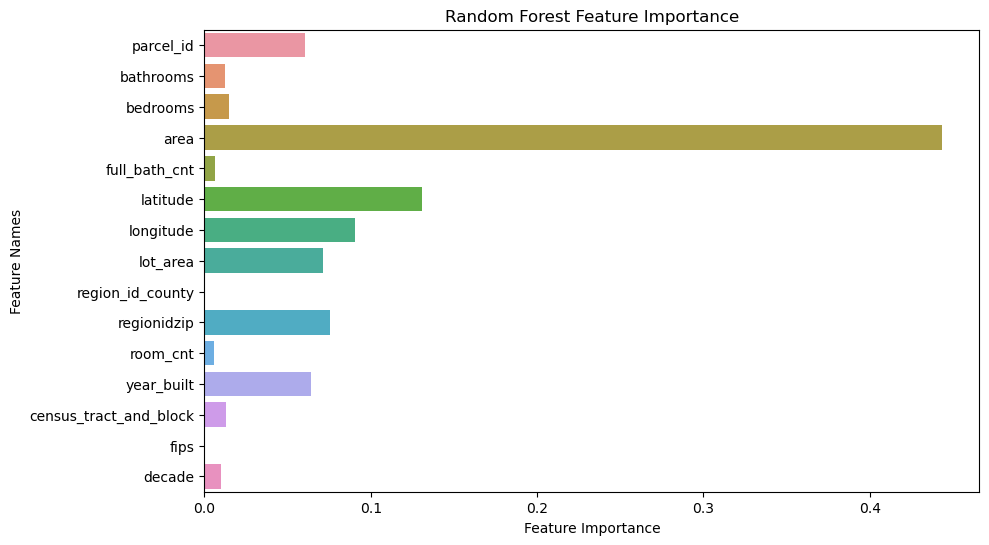

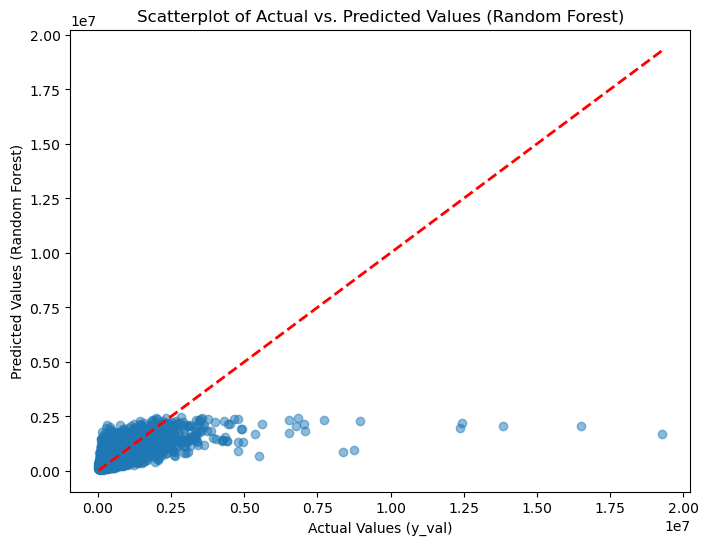

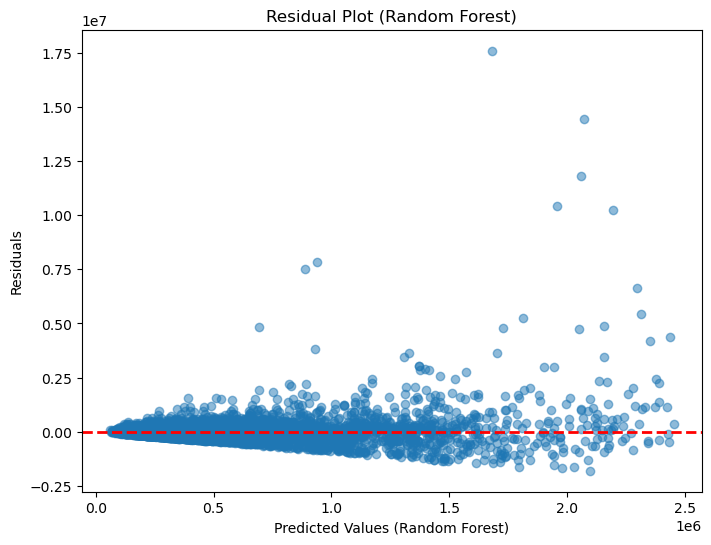

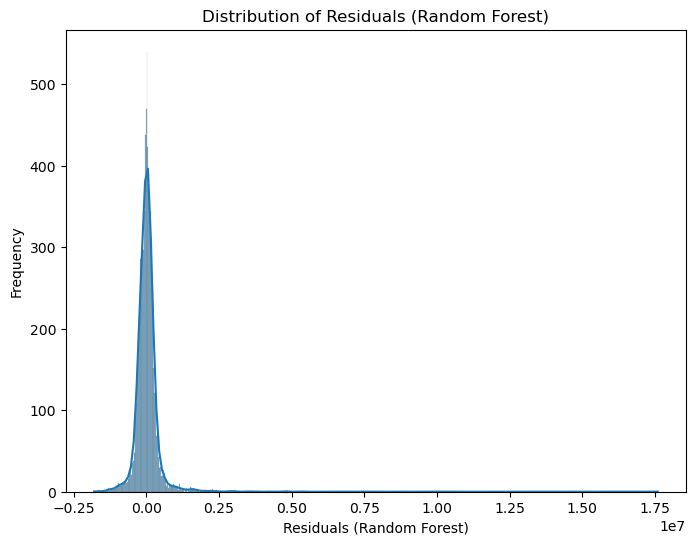

In [33]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you have trained your Random Forest Regression model (rf_model) using your train_and_evaluate_model function

feature_names = X_train.columns.to_list()

# Feature Importance Plot
feature_importance = trained_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Random Forest Feature Importance")
plt.show()

# Scatterplot of Actual vs. Predicted Values
predicted_val_rf = trained_model.predict(X_val)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, predicted_val_rf, alpha=0.5)
plt.xlabel("Actual Values (y_val)")
plt.ylabel("Predicted Values (Random Forest)")
plt.title("Scatterplot of Actual vs. Predicted Values (Random Forest)")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', lw=2)
plt.show()

# Residual Plot
residuals_rf = y_val - predicted_val_rf
plt.figure(figsize=(8, 6))
plt.scatter(predicted_val_rf, residuals_rf, alpha=0.5)
plt.xlabel("Predicted Values (Random Forest)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Random Forest)")
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.show()

# Distribution of Residuals (Random Forest)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_rf, kde=True)
plt.xlabel("Residuals (Random Forest)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Random Forest)")
plt.show()


## Model 2

In [34]:
xgboost = XGBRegressor()
trained_model, train_rmse, val_rmse = train_and_evaluate_model(xgboost, X_train, y_train, X_val, y_val)

The train RMSE is 211353.60.

The validation RMSE is 530605.33.




<Figure size 1000x600 with 0 Axes>

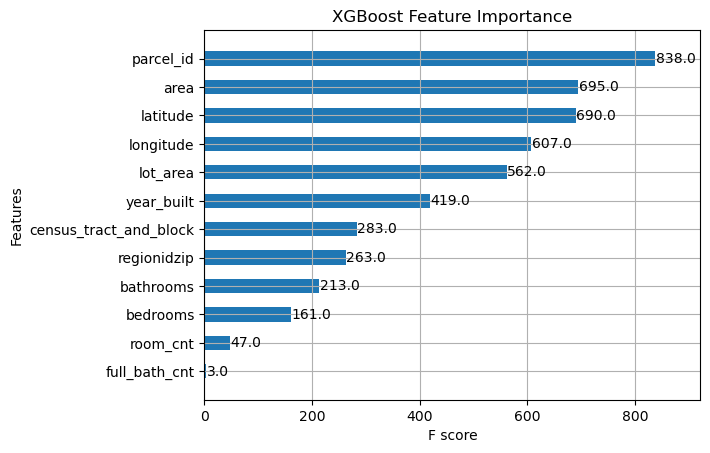

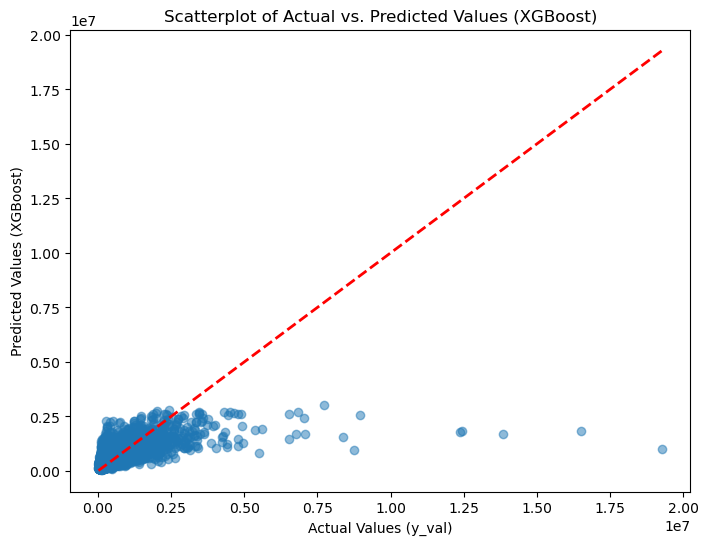

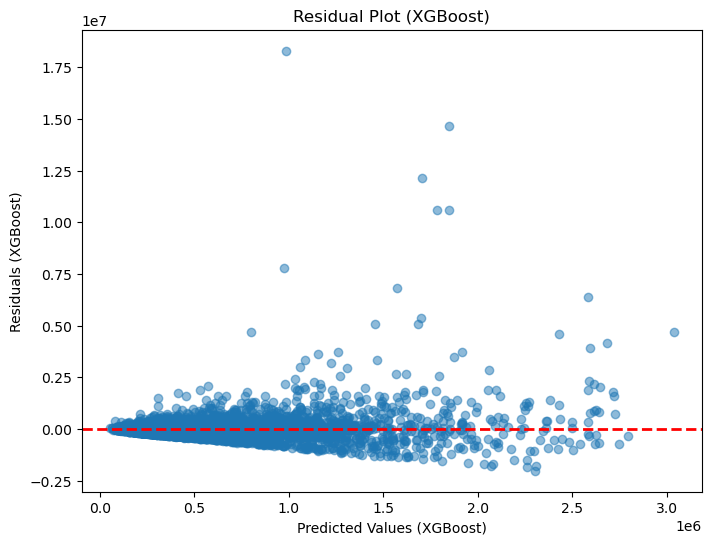

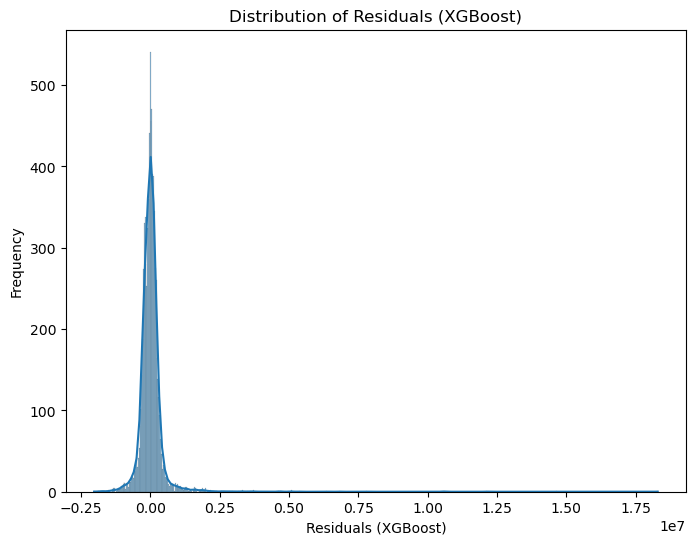

In [35]:
import xgboost as xgb

# Assuming you have trained your XGBoost Regression model (xgb_model) using your train_and_evaluate_model function

# Feature Importance Plot (XGBoost)
plt.figure(figsize=(10, 6))
xgb.plot_importance(trained_model, height=0.5)
plt.title("XGBoost Feature Importance")
plt.show()

# Scatterplot of Actual vs. Predicted Values (XGBoost)
predicted_val_xgb = trained_model.predict(X_val)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, predicted_val_xgb, alpha=0.5)
plt.xlabel("Actual Values (y_val)")
plt.ylabel("Predicted Values (XGBoost)")
plt.title("Scatterplot of Actual vs. Predicted Values (XGBoost)")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', lw=2)
plt.show()

# Residual Plot (XGBoost)
residuals_xgb = y_val - predicted_val_xgb
plt.figure(figsize=(8, 6))
plt.scatter(predicted_val_xgb, residuals_xgb, alpha=0.5)
plt.xlabel("Predicted Values (XGBoost)")
plt.ylabel("Residuals (XGBoost)")
plt.title("Residual Plot (XGBoost)")
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.show()

# Distribution of Residuals (XGBoost)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_xgb, kde=True)
plt.xlabel("Residuals (XGBoost)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (XGBoost)")
plt.show()


<Figure size 1000x600 with 0 Axes>

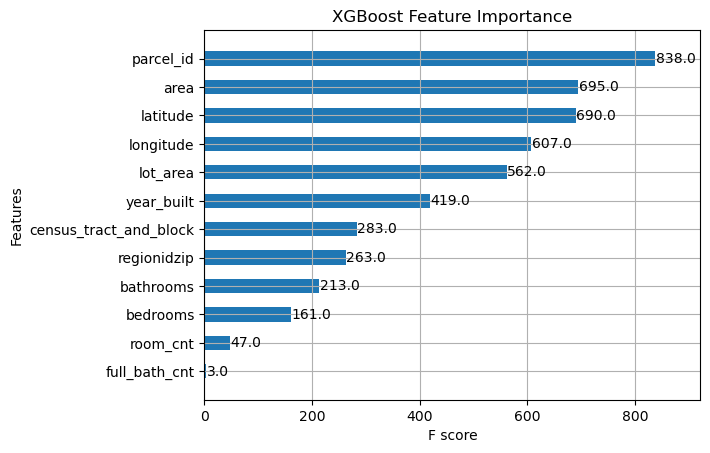

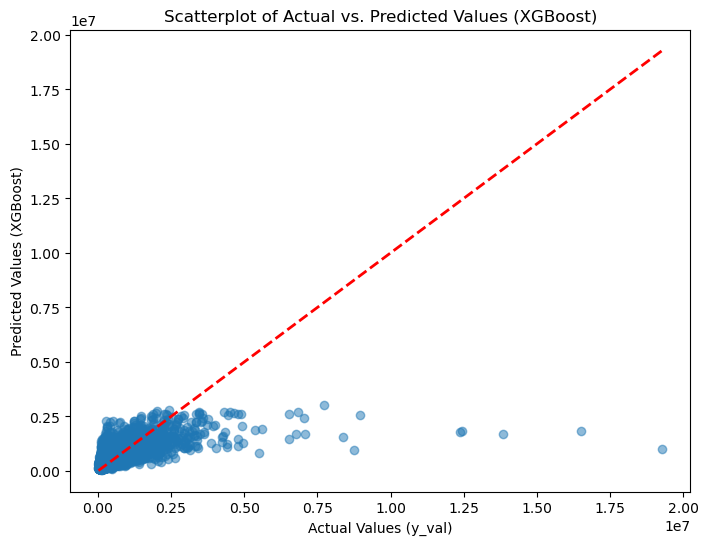

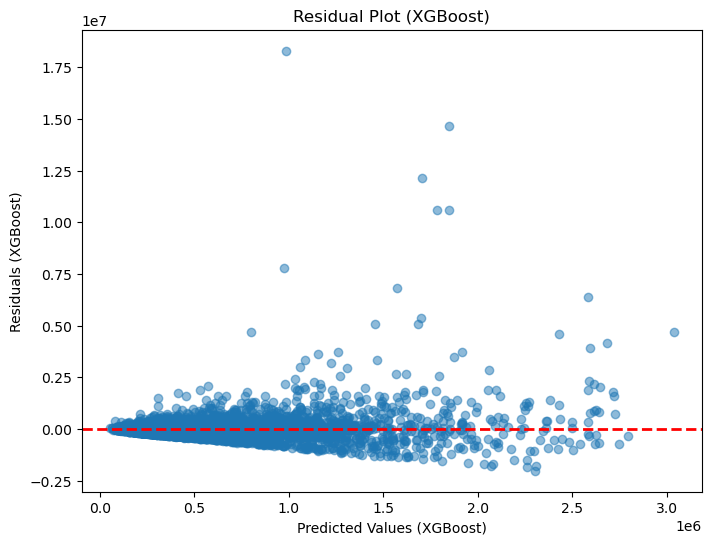

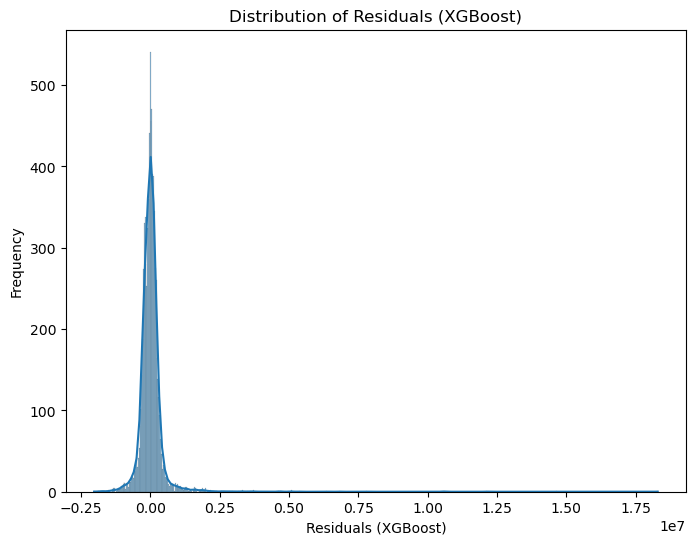

In [36]:
import xgboost as xgb

# Assuming you have trained your XGBoost Regression model (xgb_model) using your train_and_evaluate_model function

# Feature Importance Plot (XGBoost)
plt.figure(figsize=(10, 6))
xgb.plot_importance(trained_model, height=0.5)
plt.title("XGBoost Feature Importance")
plt.show()

# Scatterplot of Actual vs. Predicted Values (XGBoost)
predicted_val_xgb = trained_model.predict(X_val)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, predicted_val_xgb, alpha=0.5)
plt.xlabel("Actual Values (y_val)")
plt.ylabel("Predicted Values (XGBoost)")
plt.title("Scatterplot of Actual vs. Predicted Values (XGBoost)")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', lw=2)
plt.show()

# Residual Plot (XGBoost)
residuals_xgb = y_val - predicted_val_xgb
plt.figure(figsize=(8, 6))
plt.scatter(predicted_val_xgb, residuals_xgb, alpha=0.5)
plt.xlabel("Predicted Values (XGBoost)")
plt.ylabel("Residuals (XGBoost)")
plt.title("Residual Plot (XGBoost)")
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.show()

# Distribution of Residuals (XGBoost)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_xgb, kde=True)
plt.xlabel("Residuals (XGBoost)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (XGBoost)")
plt.show()


## Model 3

In [37]:
lm = LinearRegression()
trained_model, train_rmse, val_rmse = train_and_evaluate_model(lm, X_train, y_train, X_val, y_val)

The train RMSE is 322213.92.

The validation RMSE is 525511.56.




## Best on Test

- RandomForest maybe

## Model Results visualization

In [38]:
# display visual call function

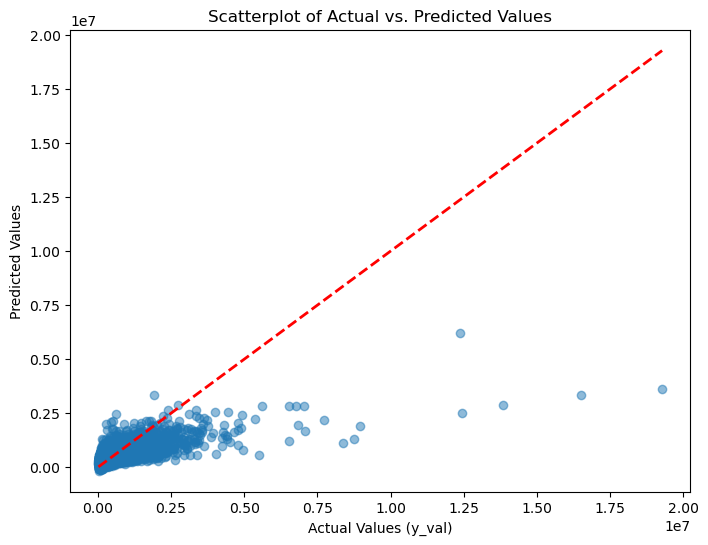

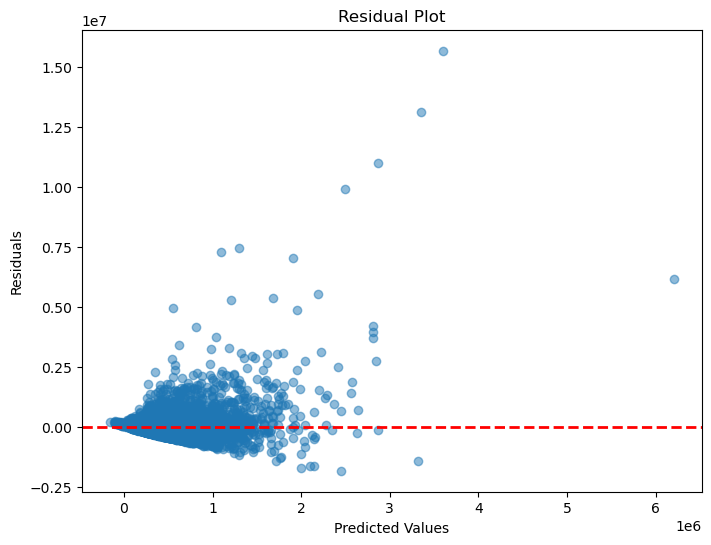

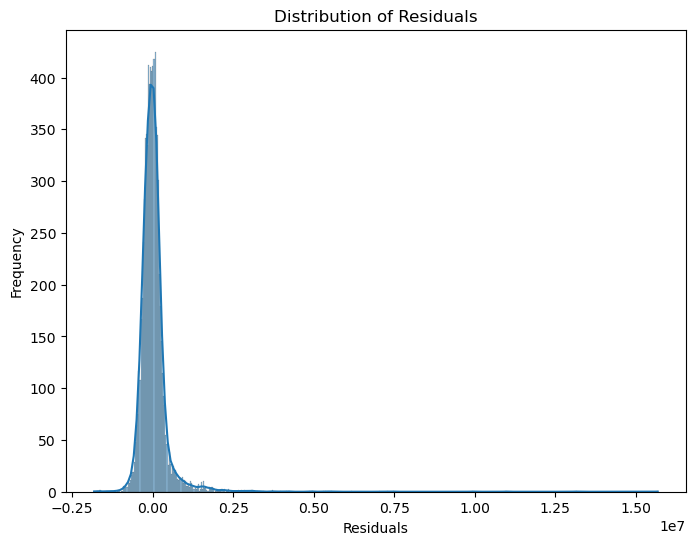

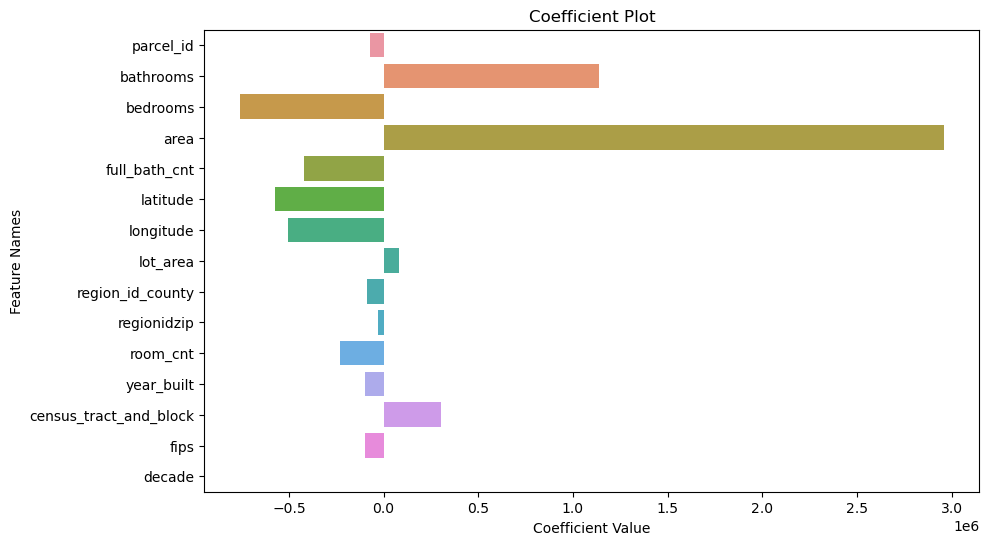

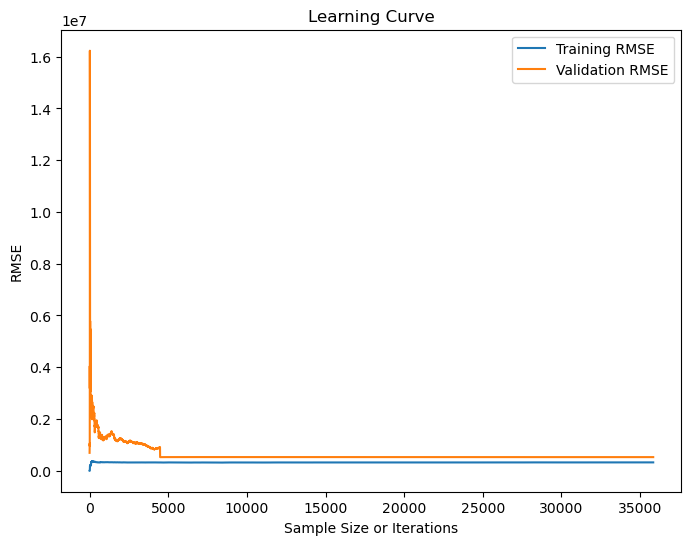

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have trained your linear regression model (lm) using your train_and_evaluate_model function

# Scatterplot of Actual vs. Predicted Values
predicted_val = trained_model.predict(X_val)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, predicted_val, alpha=0.5)
plt.xlabel("Actual Values (y_val)")
plt.ylabel("Predicted Values")
plt.title("Scatterplot of Actual vs. Predicted Values")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', lw=2)
plt.show()

# Residual Plot
residuals = y_val - predicted_val
plt.figure(figsize=(8, 6))
plt.scatter(predicted_val, residuals, alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.show()

# Distribution of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

# Coefficient Plot
coefficients = trained_model.coef_
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients, y=feature_names)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature Names")
plt.title("Coefficient Plot")
plt.show()

# Learning Curve (if you have this data)
train_rmse_values = []  # Store training RMSE values for different sample sizes or iterations
val_rmse_values = []    # Store validation RMSE values for different sample sizes or iterations

# Loop through different sample sizes or iterations and record RMSE values
for i in range(1, len(X_train) + 1):
    lm.fit(X_train[:i], y_train[:i])  # Train on a subset of the data
    train_rmse_values.append(np.sqrt(np.mean((y_train[:i] - lm.predict(X_train[:i]))**2)))
    val_rmse_values.append(np.sqrt(np.mean((y_val - lm.predict(X_val))**2)))

# Create learning curve plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(X_train) + 1), train_rmse_values, label='Training RMSE')
plt.plot(range(1, len(X_train) + 1), val_rmse_values, label='Validation RMSE')
plt.xlabel("Sample Size or Iterations")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
plt.show()


## Model Summary

- RandomForestRegression and XGBoostRegression had between 100,000 - 200,000 difference between train and validate.  
- Best overall with the test done on RandomForestRegression with a  RMSE Calculated Significance Value of $459,000.
  
- RMSE Calculated Significance Value of $459,000$ dollars does better than the baseline with $716,000$ dollars.  

# Conclusion

## Takeaways and Key findings

- Home details like the calculated area of home, lot area, bedrooms, bathrooms, full bathrooms, year built drive home value.
- Calculated area is the most important feature across all features.
- There higher priced adn larger single redidential family properties seems to be concentrated in ventura county and less larger  homes are spread on ornage and los angeles county

## Recommendations

- Gathering data on built years and lot sizes may improve price prediction for single residential family home values.
- I would recommend confirming pool on a property as it may help determine true value for properties with this information.

## Next Steps

- If i had more time I would want to gatehr more data and maybe fill null values with imputations that closely resemble data and also feature engineer data to include new features and possibily fine tune parameter for these models.m